In [1]:
import ast
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import torch
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("/app/_data/full_train.csv")
df[["day", "slice"]] = df[["day", "slice"]].astype("int")

## segmentation for different classes

In [3]:
list_classes = sorted(df["class"].unique().tolist())
classes = {list_classes[i]: i for i in range(len(list_classes))}
classes

{'large_bowel': 0, 'small_bowel': 1, 'stomach': 2}

In [4]:
train_df = pd.DataFrame()
for idx in tqdm(df.id.unique()):
    new_df = df.query("id == @idx").reset_index(drop=True)
    for part in list_classes:
        new_df.loc[0, part] = new_df[new_df["class"] == part]["segmentation"].values[0]
    train_df = train_df.append(
        new_df.loc[
            0,
            [
                "id",
                "class",
                "case",
                "day",
                "slice",
                "path",
                "img_name",
                "pixel_height",
                "pixel_width",
                "large_bowel",
                "small_bowel",
                "stomach",
            ],
        ],
        ignore_index=True,
    )

100% 38496/38496 [09:45<00:00, 65.79it/s]


In [5]:
train_df[["day", "slice"]] = train_df[["day", "slice"]].astype("int")
train_df.head()

id        class     case  day  slice  \
0  case123_day20_slice_0001  large_bowel  case123   20      1   
1  case123_day20_slice_0002  large_bowel  case123   20      2   
2  case123_day20_slice_0003  large_bowel  case123   20      3   
3  case123_day20_slice_0004  large_bowel  case123   20      4   
4  case123_day20_slice_0005  large_bowel  case123   20      5   

                                                path  \
0  /app/_data/train/case123/case123_day20/scans/s...   
1  /app/_data/train/case123/case123_day20/scans/s...   
2  /app/_data/train/case123/case123_day20/scans/s...   
3  /app/_data/train/case123/case123_day20/scans/s...   
4  /app/_data/train/case123/case123_day20/scans/s...   

                       img_name  pixel_height  pixel_width large_bowel  \
0  slice_0001_266_266_1.50_1.50           1.5          1.5         NaN   
1  slice_0002_266_266_1.50_1.50           1.5          1.5         NaN   
2  slice_0003_266_266_1.50_1.50           1.5          1.5         NaN   
3  slice_0004_266_266_1.50_1.50           1.5          1.5         NaN   
4  slice_0005_266_266_1.50_1.50           1.5          1.5         NaN   

  small_bowel stomach  
0         NaN     NaN  
1         NaN     NaN  
2         NaN     NaN  
3         NaN     NaN  
4         NaN     NaN

## previous slices

In [6]:
for case in tqdm(train_df.case.unique()):
    case_df = train_df[train_df["case"] == case]
    for day in case_df.day.unique():
        day_df = case_df[case_df["day"] == day]
        for ix in day_df.index:
            slice_ix = day_df.loc[ix, "slice"]
            previous_val = day_df.query(
                "day == @day and slice == @slice_ix - 1 and case == @case"
            )[["id", "path"]].values
            pre_previous_val = day_df.query(
                "day == @day and slice == @slice_ix - 2 and case == @case"
            )[["id", "path"]].values
            if previous_val.size:
                previous_slice, previous_path = previous_val[0]
                train_df.loc[ix, "prev_slice"] = previous_slice
                train_df.loc[ix, "prev_path"] = previous_path
            if pre_previous_val.size:
                prev_prev_slice, prev_prev_path = pre_previous_val[0]
                train_df.loc[ix, "prev_prev_slice"] = prev_prev_path
                train_df.loc[ix, "prev_prev_path"] = prev_prev_path

100% 85/85 [06:13<00:00,  4.39s/it]


In [7]:
train_df.head()

id        class     case  day  slice  \
0  case123_day20_slice_0001  large_bowel  case123   20      1   
1  case123_day20_slice_0002  large_bowel  case123   20      2   
2  case123_day20_slice_0003  large_bowel  case123   20      3   
3  case123_day20_slice_0004  large_bowel  case123   20      4   
4  case123_day20_slice_0005  large_bowel  case123   20      5   

                                                path  \
0  /app/_data/train/case123/case123_day20/scans/s...   
1  /app/_data/train/case123/case123_day20/scans/s...   
2  /app/_data/train/case123/case123_day20/scans/s...   
3  /app/_data/train/case123/case123_day20/scans/s...   
4  /app/_data/train/case123/case123_day20/scans/s...   

                       img_name  pixel_height  pixel_width large_bowel  \
0  slice_0001_266_266_1.50_1.50           1.5          1.5         NaN   
1  slice_0002_266_266_1.50_1.50           1.5          1.5         NaN   
2  slice_0003_266_266_1.50_1.50           1.5          1.5         NaN   
3  slice_0004_266_266_1.50_1.50           1.5          1.5         NaN   
4  slice_0005_266_266_1.50_1.50           1.5          1.5         NaN   

  small_bowel stomach                prev_slice  \
0         NaN     NaN                       NaN   
1         NaN     NaN  case123_day20_slice_0001   
2         NaN     NaN  case123_day20_slice_0002   
3         NaN     NaN  case123_day20_slice_0003   
4         NaN     NaN  case123_day20_slice_0004   

                                           prev_path  \
0                                                NaN   
1  /app/_data/train/case123/case123_day20/scans/s...   
2  /app/_data/train/case123/case123_day20/scans/s...   
3  /app/_data/train/case123/case123_day20/scans/s...   
4  /app/_data/train/case123/case123_day20/scans/s...   

                                     prev_prev_slice  \
0                                                NaN   
1                                                NaN   
2  /app/_data/train/case123/case123_day20/scans/s...   
3  /app/_data/train/case123/case123_day20/scans/s...   
4  /app/_data/train/case123/case123_day20/scans/s...   

                                      prev_prev_path  
0                                                NaN  
1                                                NaN  
2  /app/_data/train/case123/case123_day20/scans/s...  
3  /app/_data/train/case123/case123_day20/scans/s...  
4  /app/_data/train/case123/case123_day20/scans/s...

In [8]:
train_df["is_mask"] = train_df[["large_bowel", "small_bowel", "stomach"]].any(1)

In [9]:
train_df["is_large_bowel"] = train_df["large_bowel"].notna()
train_df["is_small_bowel"] = train_df["small_bowel"].notna()
train_df["is_stomach"] = train_df["stomach"].notna()

In [10]:
train_df.to_csv("/app/_data/train_main.csv", index=False)

## png to npy with masks and previous slices

In [11]:
def rle_decode(mask_array, img_shape):
    h, w = img_shape
    img_mask = np.zeros(h * w)
    rle_mask = np.array(mask_array.split(), dtype="int")
    starts = rle_mask[0::2] - 1
    ends = rle_mask[1::2] + starts
    for start, end in zip(starts, ends):
        img_mask[start:end] = 1
    return img_mask.reshape([h, w])

In [12]:
def make_npy(df, idx, n_layers=1):
    path = df.loc[idx, "path"]
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    rles = df.loc[idx, ["large_bowel", "small_bowel", "stomach"]]
    masks = np.zeros([img.shape[0], img.shape[1], 3])
    for n in range(3):
        if rles[n] == rles[n]:
            masks[:, :, n] = rle_decode(rles[n], img.shape[:2])
    if n_layers != 1:
        paths = df.loc[idx, ["prev_path", "prev_prev_path"]]
        imgs = np.zeros([img.shape[0], img.shape[1], 3])
        imgs[:, :, 0] = img
        for k in range(1, 3):
            if paths[k - 1] == paths[k - 1]:
                img_prev = cv2.imread(paths[k - 1], cv2.IMREAD_UNCHANGED)
                if img_prev.shape[:2] != img.shape[:]:
                    img_prev = cv2.resize(img_prev, img.size[:2])
                imgs[:, :, k] = img_prev
        return np.dstack([imgs, masks])
    else:
        return np.dstack([img, masks])

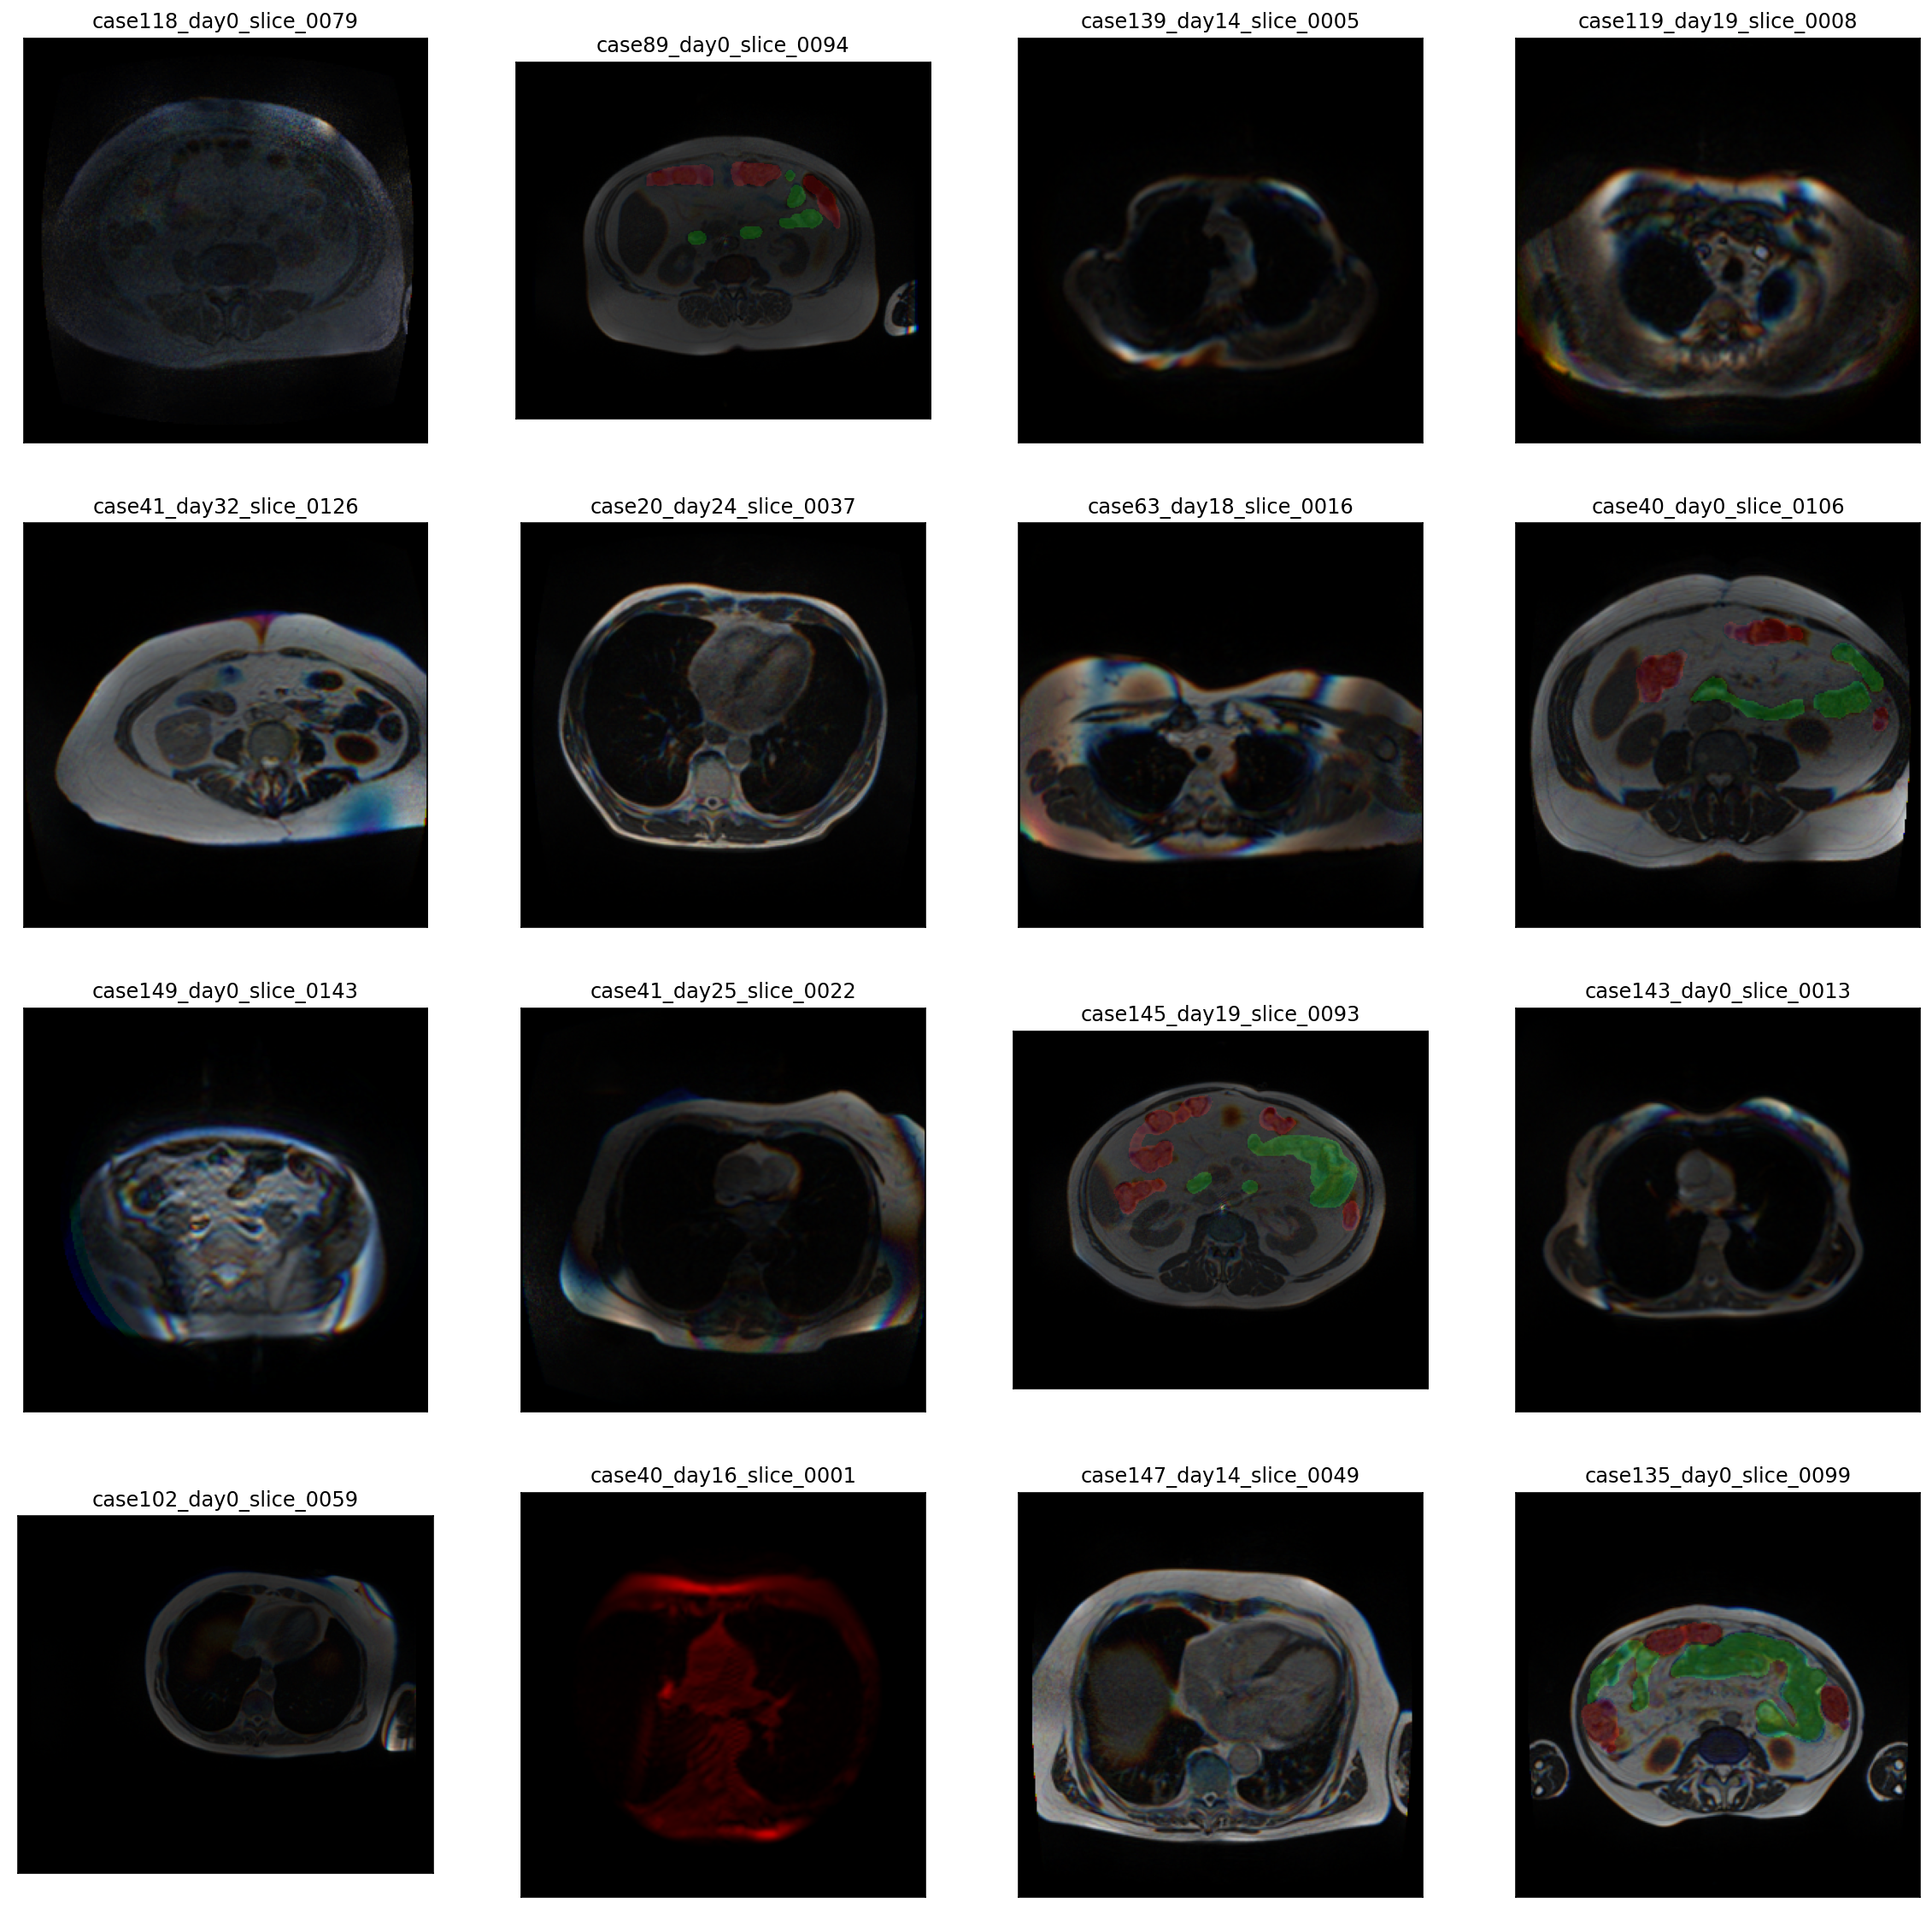

In [13]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ix = train_df.index[np.random.randint(train_df.index.shape[0])]
    img = make_npy(train_df, ix, 3)
    plt.subplot(4, 4, i + 1)
    plt.title(train_df.loc[ix, "id"])
    plt.imshow(img[:, :, :-3] / img.max())
    plt.imshow(img[:, :, -3:], alpha=0.2)
    plt.xticks([])
    plt.yticks([])
plt.show();

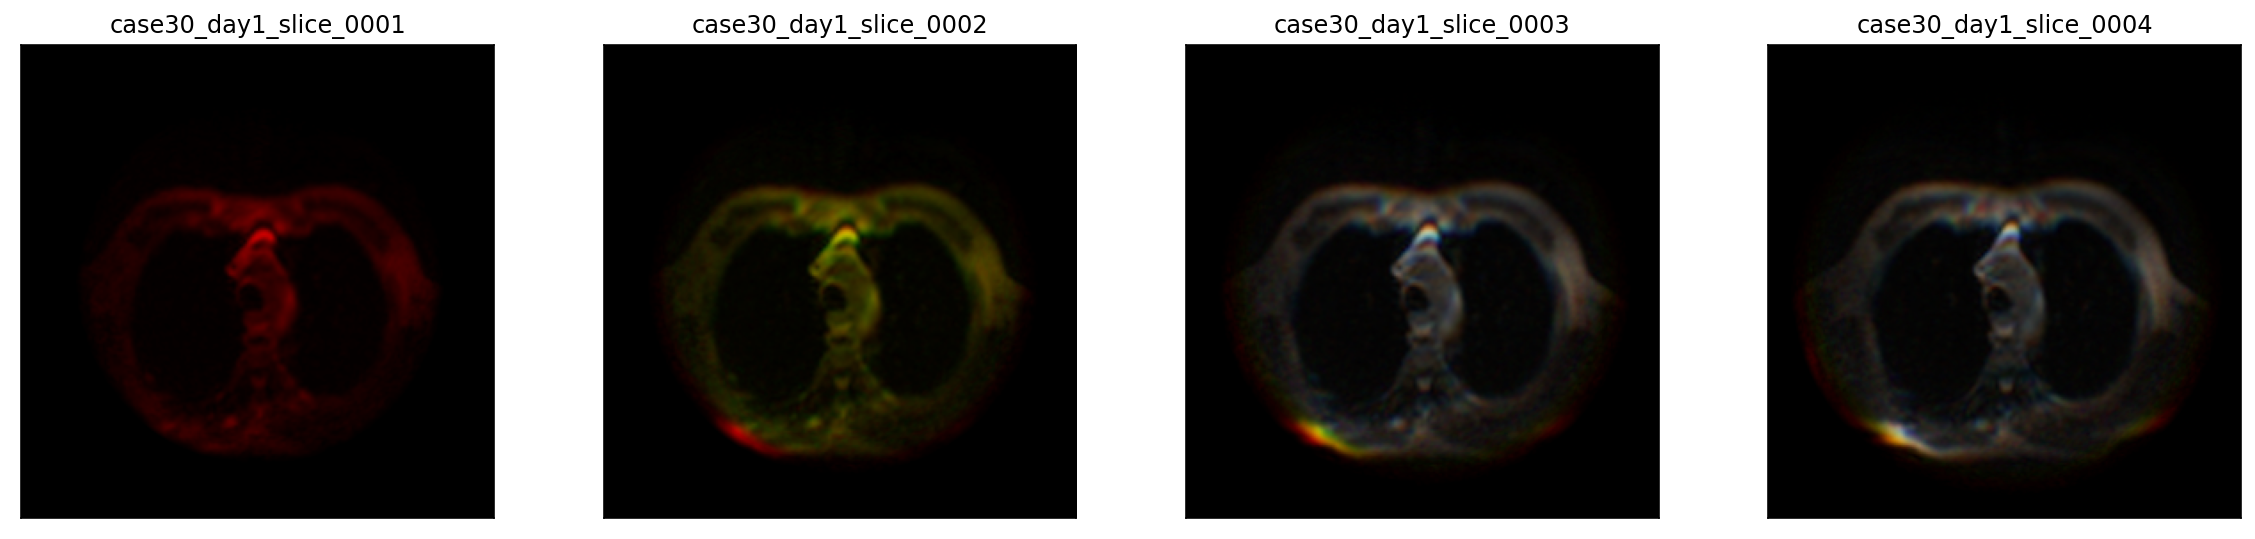

In [14]:
plt.figure(figsize=(20, 20))
for i in range(4):
    ix = 38208 + i
    img = make_npy(train_df, ix, 3)
    plt.subplot(4, 4, i + 1)
    plt.title(train_df.loc[ix, "id"])
    plt.imshow(img[:, :, :-3] / img.max())
    plt.imshow(img[:, :, -3:], alpha=0.2)
    plt.xticks([])
    plt.yticks([])
plt.show();

In [15]:
for ix in tqdm(train_df.index):
    img = make_npy(train_df, ix, 3)
    img_name = train_df.loc[ix, "id"]
    np.save(f"/app/_data/npy/{img_name}", img)

100% 38496/38496 [06:36<00:00, 97.14it/s] 


## train/test split

In [16]:
df = pd.read_csv("/app/_data/train_main.csv")

In [17]:
gkf = StratifiedGroupKFold(n_splits=6, shuffle=True, random_state=42)

In [18]:
for n, (train_ixs, val_ix) in enumerate(
    gkf.split(
        X=df,
        y=df["is_mask"],
        groups=df["case"],
    )
):
    df.loc[val_ix, "fold"] = n

In [22]:
for fold in range(5):
    print(f'Proportion of images with mask and without in  fold #{int(fold)}')
    df[df["fold"] != fold][
        ["is_mask", "is_large_bowel", "is_small_bowel", "is_stomach"]
    ].sum() / df[df["fold"] == fold][
        ["is_mask", "is_large_bowel", "is_small_bowel", "is_stomach"]
    ].sum()

Proportion of images with mask and without in  fold #0


is_mask           4.671795
is_large_bowel    4.854115
is_small_bowel    4.490686
is_stomach        4.598313
dtype: float64

Proportion of images with mask and without in  fold #1


is_mask           5.697618
is_large_bowel    5.840699
is_small_bowel    5.854957
is_stomach        5.315520
dtype: float64

Proportion of images with mask and without in  fold #2


is_mask           5.801968
is_large_bowel    5.745690
is_small_bowel    5.804982
is_stomach        5.625960
dtype: float64

Proportion of images with mask and without in  fold #3


is_mask           5.727494
is_large_bowel    5.551163
is_small_bowel    5.554125
is_stomach        5.912660
dtype: float64

Proportion of images with mask and without in  fold #4


is_mask           4.006035
is_large_bowel    4.251678
is_small_bowel    4.086739
is_stomach        4.184495
dtype: float64

In [20]:
df[df['is_mask']]

id        class     case  day  slice  \
64     case123_day20_slice_0065  large_bowel  case123   20     65   
65     case123_day20_slice_0066  large_bowel  case123   20     66   
66     case123_day20_slice_0067  large_bowel  case123   20     67   
67     case123_day20_slice_0068  large_bowel  case123   20     68   
68     case123_day20_slice_0069  large_bowel  case123   20     69   
...                         ...          ...      ...  ...    ...   
38484    case30_day0_slice_0133  large_bowel   case30    0    133   
38485    case30_day0_slice_0134  large_bowel   case30    0    134   
38486    case30_day0_slice_0135  large_bowel   case30    0    135   
38487    case30_day0_slice_0136  large_bowel   case30    0    136   
38488    case30_day0_slice_0137  large_bowel   case30    0    137   

                                                    path  \
64     /app/_data/train/case123/case123_day20/scans/s...   
65     /app/_data/train/case123/case123_day20/scans/s...   
66     /app/_data/train/case123/case123_day20/scans/s...   
67     /app/_data/train/case123/case123_day20/scans/s...   
68     /app/_data/train/case123/case123_day20/scans/s...   
...                                                  ...   
38484  /app/_data/train/case30/case30_day0/scans/slic...   
38485  /app/_data/train/case30/case30_day0/scans/slic...   
38486  /app/_data/train/case30/case30_day0/scans/slic...   
38487  /app/_data/train/case30/case30_day0/scans/slic...   
38488  /app/_data/train/case30/case30_day0/scans/slic...   

                           img_name  pixel_height  pixel_width  \
64     slice_0065_266_266_1.50_1.50           1.5          1.5   
65     slice_0066_266_266_1.50_1.50           1.5          1.5   
66     slice_0067_266_266_1.50_1.50           1.5          1.5   
67     slice_0068_266_266_1.50_1.50           1.5          1.5   
68     slice_0069_266_266_1.50_1.50           1.5          1.5   
...                             ...           ...          ...   
38484  slice_0133_266_266_1.50_1.50           1.5          1.5   
38485  slice_0134_266_266_1.50_1.50           1.5          1.5   
38486  slice_0135_266_266_1.50_1.50           1.5          1.5   
38487  slice_0136_266_266_1.50_1.50           1.5          1.5   
38488  slice_0137_266_266_1.50_1.50           1.5          1.5   

                                             large_bowel  ...  \
64                                                   NaN  ...   
65                                                   NaN  ...   
66                                                   NaN  ...   
67                                                   NaN  ...   
68                                                   NaN  ...   
...                                                  ...  ...   
38484  17695 8 17957 23 18213 39 18477 45 18741 52 19...  ...   
38485  17694 5 17957 10 18215 2 18219 17 18478 32 187...  ...   
38486  17957 1 18219 10 18482 16 18744 23 19008 43 19...  ...   
38487  18746 7 19009 23 19038 7 19273 44 19537 49 198...  ...   
38488  18746 2 19010 8 19040 3 19274 25 19302 12 1953...  ...   

                                                 stomach  \
64     28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...   
65     27561 8 27825 11 28090 13 28355 14 28620 15 28...   
66     15323 4 15587 8 15852 10 16117 11 16383 12 166...   
67     14792 5 15056 9 15321 11 15587 11 15852 13 161...   
68     14526 6 14789 12 15054 14 15319 16 15584 17 15...   
...                                                  ...   
38484                                                NaN   
38485                                                NaN   
38486                                                NaN   
38487                                                NaN   
38488                                                NaN   

                     prev_slice  \
64     case123_day20_slice_0064   
65     case123_day20_slice_0065   
66     case123_day20_slice_0066   
67     case123_day20_slice_0067   
68     ca